In [1]:
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras.models import Model # for creating assembling a Neural Network model
from keras import Input # for instantiating a keras tensor and specifying input dimensions
from keras.layers import Dense, Lambda # adding layers to the Neural Network model
from tensorflow.keras.utils import plot_model # for plotting model diagram
from keras import backend as K # for access to Keras backend for reparameterization and creating custom loss function

# Data manipulation
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version

# Visualization
import matplotlib 
import matplotlib.pyplot as plt # for plotting model loss
print('matplotlib: %s' % matplotlib.__version__) # print version
import graphviz # for showing model diagram
print('graphviz: %s' % graphviz.__version__) # print version
import plotly
import plotly.express as px # for data visualization
print('plotly: %s' % plotly.__version__) # print version

# Other utilities
import sys
import os


Tensorflow/Keras: 2.12.0
numpy: 1.23.1
matplotlib: 3.7.1
graphviz: 0.20.1
plotly: 5.15.0


Shape of X_train:  (60000, 28, 28)
Shape of y_train:  (60000,)
Shape of X_test:  (10000, 28, 28)
Shape of y_test:  (10000,)


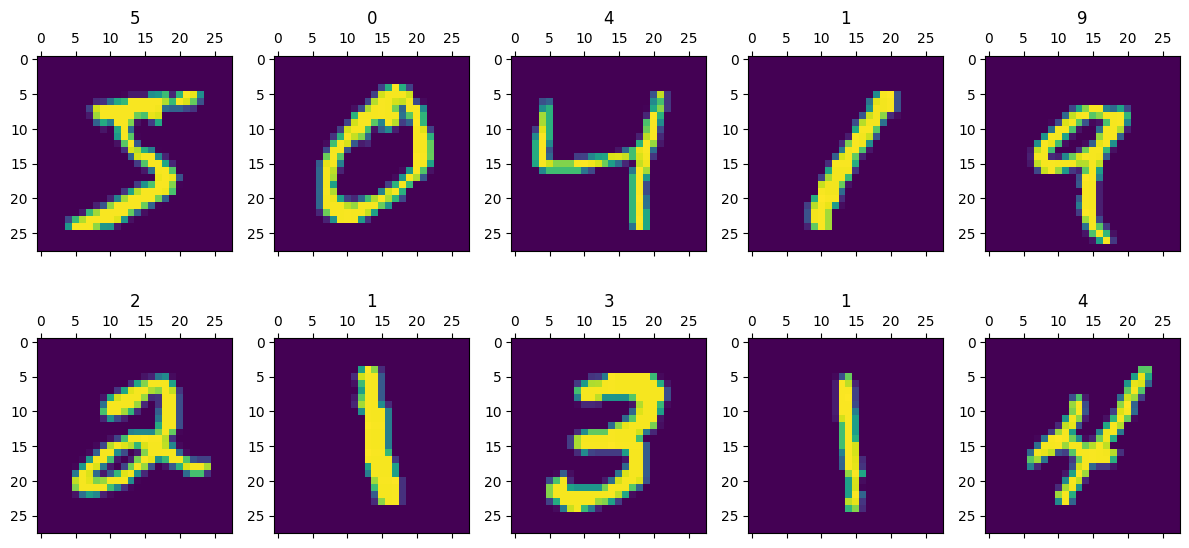

In [2]:
# Load digits data 
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# Print shapes
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

# Normalize input data (divide by 255) 
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

# Display images of the first 10 digits in the training set and their true lables
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(X_train[n])
        axs[i,j].set(title=y_train[n])
        n=n+1
plt.show() 

In [3]:
# Reshape input data
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

# Print shapes
print("New shape of X_train: ", X_train.shape)
print("New shape of X_test: ", X_test.shape)

New shape of X_train:  (60000, 784)
New shape of X_test:  (10000, 784)


In [4]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_sigma) * epsilon

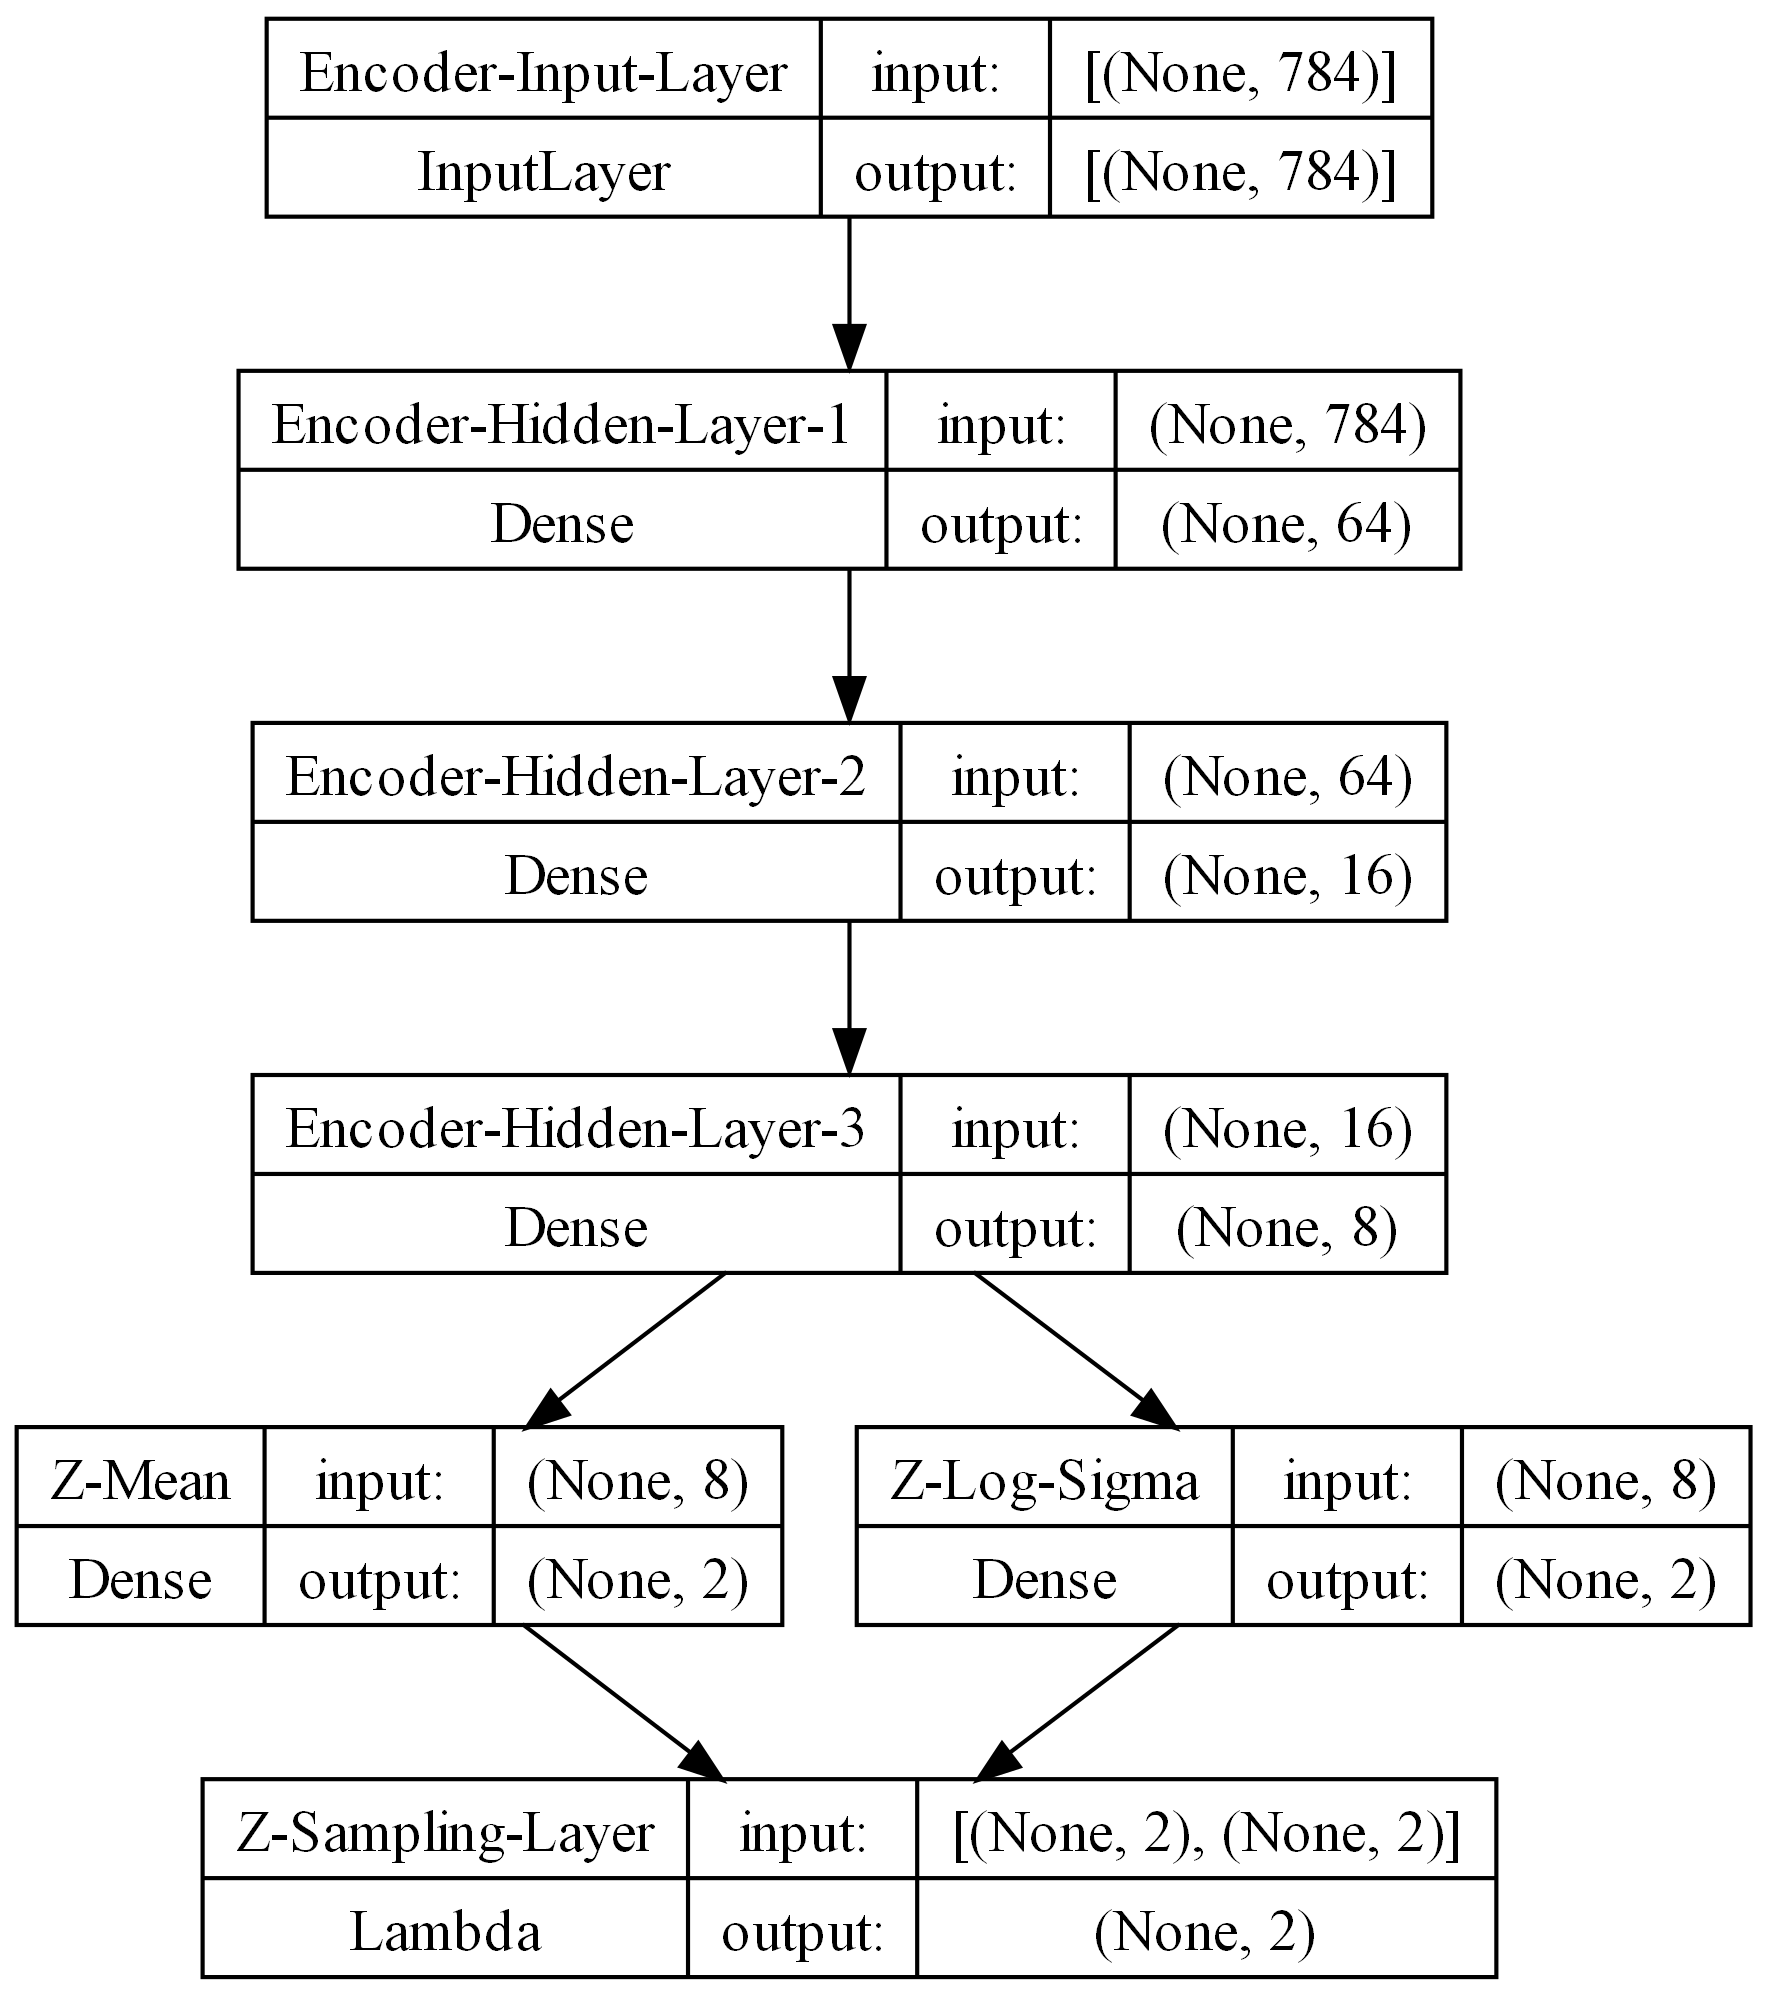

In [5]:
# Specify dimensions for input/output and latent space layers
original_dim = 784 # number of neurons at the input layer (28 * 28 = 784)
latent_dim = 2 # latent space dimension

# ********** Create Encoder **********

#--- Input Layer 
visible = keras.Input(shape=(original_dim,), name='Encoder-Input-Layer')

#--- Hidden Layer
h_enc1 = Dense(units=64, activation='relu', name='Encoder-Hidden-Layer-1')(visible)
h_enc2 = Dense(units=16, activation='relu', name='Encoder-Hidden-Layer-2')(h_enc1)
h_enc3 = Dense(units=8, activation='relu', name='Encoder-Hidden-Layer-3')(h_enc2)

#--- Custom Latent Space Layer
z_mean = Dense(units=latent_dim, name='Z-Mean')(h_enc3) # Mean component
z_log_sigma = Dense(units=latent_dim, name='Z-Log-Sigma')(h_enc3) # Standard deviation component
z = Lambda(sampling, name='Z-Sampling-Layer')([z_mean, z_log_sigma]) # Z sampling layer

#--- Create Encoder model
encoder = Model(visible, [z_mean, z_log_sigma, z], name='Encoder-Model')

# Display model diagram
plot_model(encoder, show_shapes=True, dpi=300)

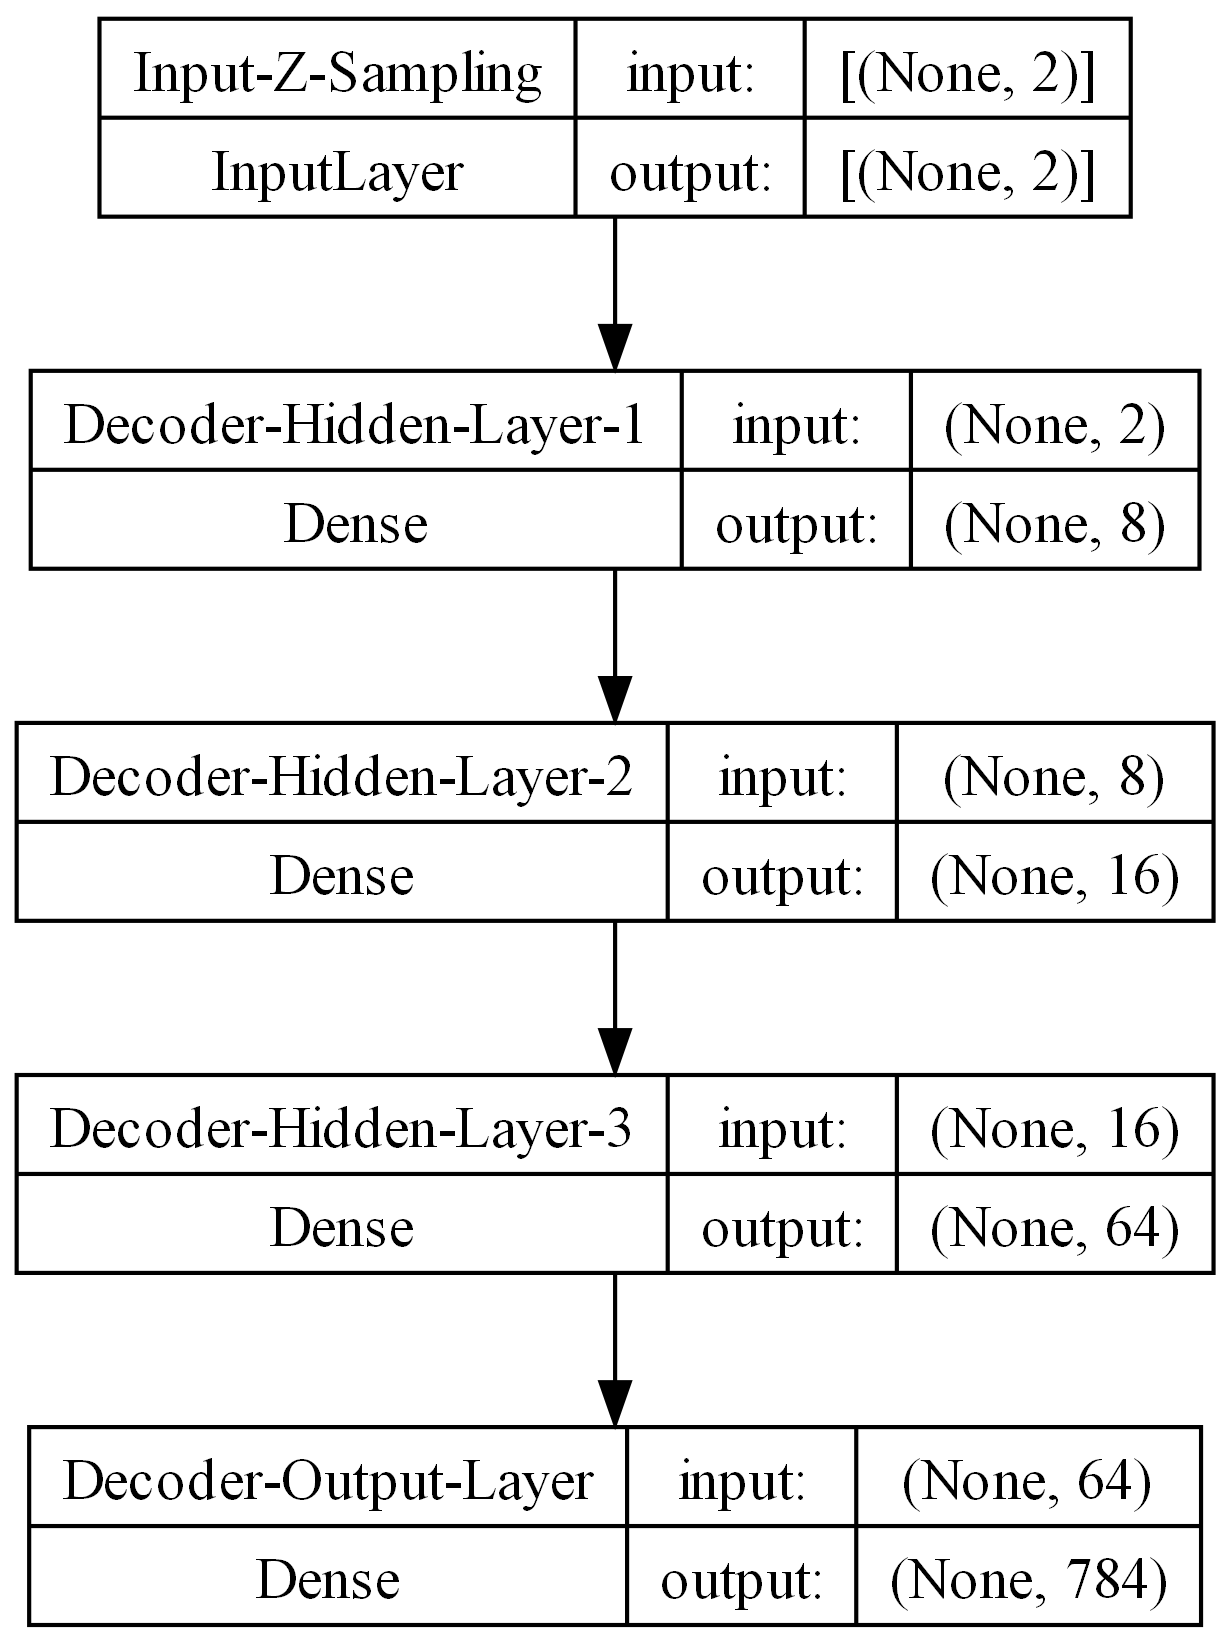

In [6]:
# ********** Create Decoder **********

#--- Input Layer 
latent_inputs = Input(shape=(latent_dim,), name='Input-Z-Sampling')

#--- Hidden Layer
h_dec = Dense(units=8, activation='relu', name='Decoder-Hidden-Layer-1')(latent_inputs)
h_dec2 = Dense(units=16, activation='relu', name='Decoder-Hidden-Layer-2')(h_dec)
h_dec3 = Dense(units=64, activation='relu', name='Decoder-Hidden-Layer-3')(h_dec2)

#--- Output Layer
outputs = Dense(original_dim, activation='sigmoid', name='Decoder-Output-Layer')(h_dec3)

#--- Create Decoder model
decoder = Model(latent_inputs, outputs, name='Decoder-Model')

# Display model diagram
plot_model(decoder, show_shapes=True, dpi=300)

In [7]:
# Define outputs from a VAE model by specifying how the encoder-decoder models are linked
outpt = decoder(encoder(visible)[2]) # note, outputs available from encoder model are z_mean, z_log_sigma and z. We take z by specifying [2]
# Instantiate a VAE model
vae = Model(inputs=visible, outputs=outpt, name='VAE-Model')

In [8]:
# Reconstruction loss compares inputs and outputs and tries to minimise the difference
r_loss = original_dim * keras.losses.mse(visible, outpt)  # use MSE

# KL divergence loss compares the encoded latent distribution Z with standard Normal distribution and penalizes if it's too different
kl_loss =  -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = 1)

# The VAE loss is a combination of reconstruction loss and KL loss
vae_loss = K.mean(r_loss + kl_loss)

# Add loss to the model and compile it
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

Epoch 1/25
3750/3750 [==============================] - 10s 2ms/step - loss: 46.7697 - val_loss: 41.6775
Epoch 2/25
3750/3750 [==============================] - 8s 2ms/step - loss: 40.5510 - val_loss: 39.2609
Epoch 3/25
3750/3750 [==============================] - 8s 2ms/step - loss: 38.6955 - val_loss: 38.1199
Epoch 4/25
3750/3750 [==============================] - 8s 2ms/step - loss: 37.6425 - val_loss: 37.0539
Epoch 5/25
3750/3750 [==============================] - 8s 2ms/step - loss: 36.9021 - val_loss: 36.4709
Epoch 6/25
3750/3750 [==============================] - 9s 3ms/step - loss: 36.3651 - val_loss: 36.0229
Epoch 7/25
3750/3750 [==============================] - 9s 2ms/step - loss: 35.9294 - val_loss: 35.5615
Epoch 8/25
3750/3750 [==============================] - 8s 2ms/step - loss: 35.6430 - val_loss: 35.2977
Epoch 9/25
3750/3750 [==============================] - 9s 2ms/step - loss: 35.3758 - val_loss: 35.1524
Epoch 10/25
3750/3750 [==============================] - 7s 2ms

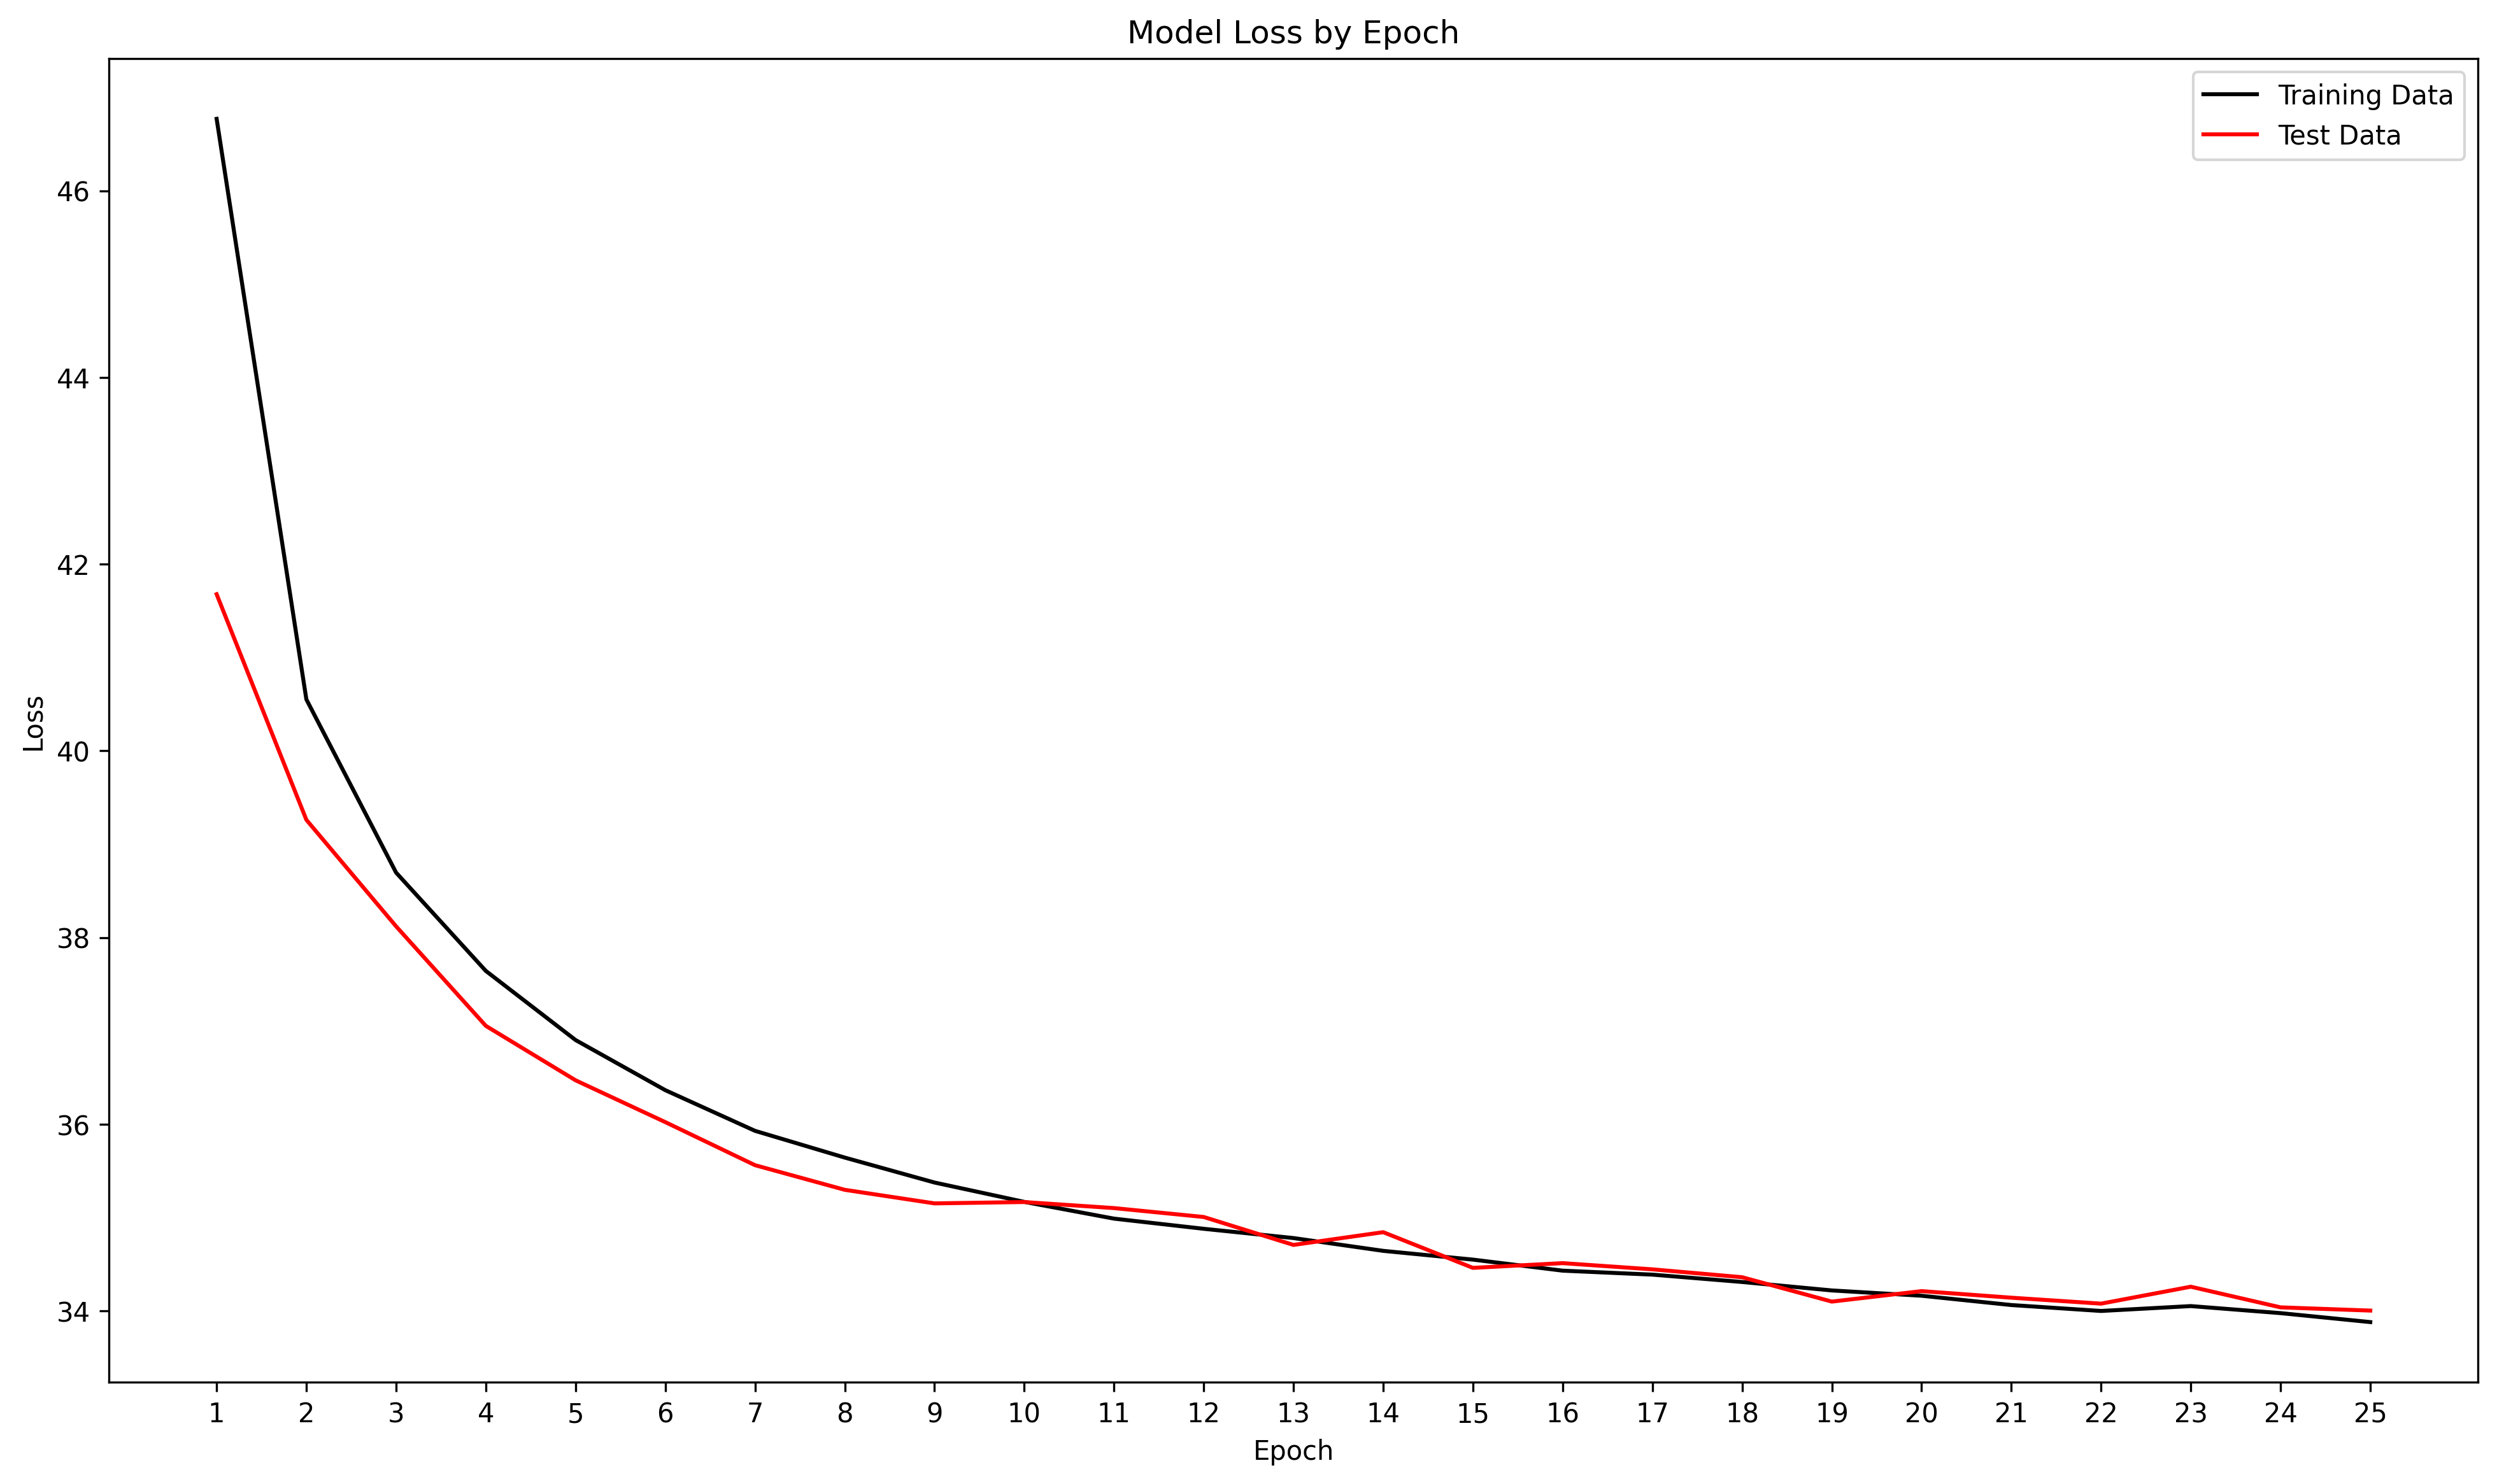

In [9]:
# Train VAE model
history = vae.fit(X_train, X_train, epochs=25, batch_size=16, validation_data=(X_test, X_test))

# Plot a loss chart
fig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='Model Loss by Epoch', loc='center')

ax.plot(history.history['loss'], label='Training Data', color='black')
ax.plot(history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.xticks(ticks=np.arange(len(history.history['loss']), step=1), labels=np.arange(1, len(history.history['loss'])+1, step=1))
plt.legend()
plt.show()

In [17]:
# Use encoder model to encode inputs into a latent space
X_test_encoded = encoder.predict(X_test)

# Recall that our encoder returns 3 arrays: z-mean, z-log-sigma and z. We plot the values for z
# Create a scatter plot
fig = px.scatter(None, x=X_test_encoded[2][:,0], y=X_test_encoded[2][:,1], 
                 opacity=1, color=y_test.astype(str))

# Change chart background color
fig.update_layout(dict(plot_bgcolor = 'white'))

# Update axes lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='white', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='white', 
                 showline=True, linewidth=1, linecolor='white',
                 title_font=dict(size=10), tickfont=dict(size=10))

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='white', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='white', 
                 showline=True, linewidth=1, linecolor='white',
                 title_font=dict(size=10), tickfont=dict(size=10))

# Set figure title
fig.update_layout(title_text="Representacion del espacio latente")

# Update marker size
fig.update_traces(marker=dict(size=5))

# Increase legend font size
fig.update_layout(legend_font=dict(size=20))


fig.show()

313/313 [==============================] - 0s 1ms/step


1/1 [==============================] - 0s 75ms/step


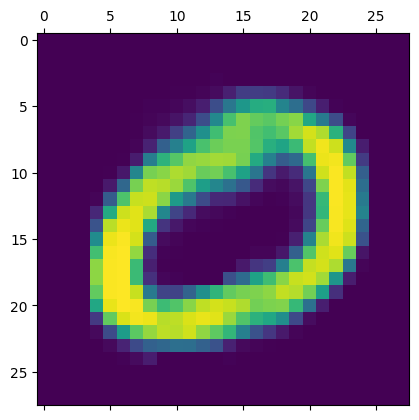

In [11]:
# Input latent space coordinates
z_sample_digit=[[0,2.5]]

# Decode latent inputs (i.e., generate new outputs)
digit_decoded = decoder.predict(z_sample_digit)

# Reshape and display the image
plt.matshow(digit_decoded.reshape(28,28))
plt.show()

1/1 [==============================] - 0s 17ms/step


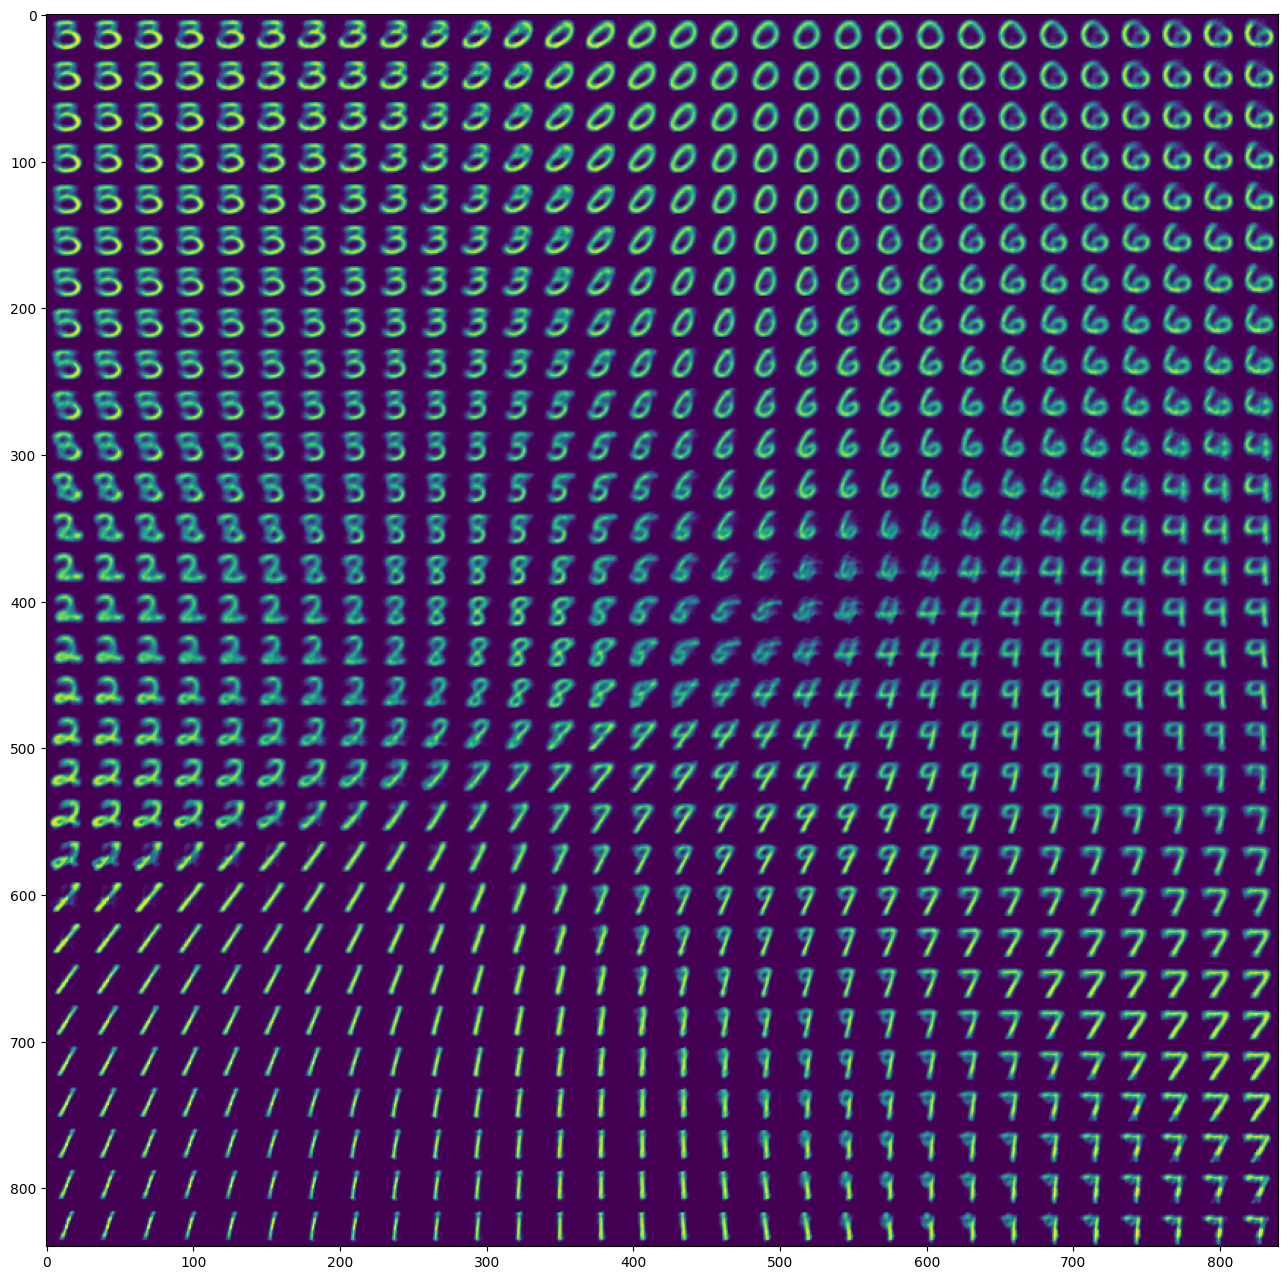

In [12]:
# Display a 2D manifold of the digits
n = 30  # figure with 30x30 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# We will sample n points within [-1.5, 1.5] standard deviations
grid_x = np.linspace(1.5, -1.5, n)
grid_y = np.linspace(-1.5, 1.5, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        # Generate an image using a decoder model
        x_decoded = decoder.predict(z_sample)
        #x_decoded = np.clip(x_decoded, 0.25, 0.75) # we could use cliping to make digit edges thicker
        
        # Reshape from 784 to original digit size (28x28)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

# Plot figure
plt.figure(figsize=(18, 16))
plt.imshow(figure)
plt.show()